# Índice

1. [Preparación y Limpieza de los Datos](#preparación-y-limpieza-de-los-datos)
2. [Matriz de Correlación](#matriz-de-correlación)
3. [Definición de Predictores y Objetivos](#definición-de-predictores-y-objetivos)
4. [Normalización y Separación de los Datos](#normalización-y-separación-de-los-datos)
5. [Definición y Configuración de los Modelos](#definición-y-configuración-de-los-modelos)
6. [Optimización, Evaluación y Comparación de Modelos](#optimización-evaluación-y-comparación-de-modelos)


imports
- pandas
- numpy
- seaborn
- matplotlib
- sklearn
- warnings 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# **Preproceso del Dataset**
El código realiza la carga y preprocesamiento de datos de calidad del aire desde un archivo CSV.

### **Carga de datos**  
Se carga el archivo de datos utilizando la librería `pandas`, especificando el delimitador adecuado para su correcta interpretación.

### **Conversión de fechas y creación de variables derivadas**  
Se convierten las columnas de fecha a un formato de fecha y hora adecuado. Luego, se extraen componentes como el día, mes y año, creando nuevas columnas con estos valores.  

### **Conversión de la columna de hora**  
Se transforma la columna de tiempo en un formato de hora reconocible para facilitar su manipulación.

### **Mapeo de días de la semana**  
Se genera una nueva columna que almacena el nombre del día de la semana correspondiente a cada fecha y se convierte a valores numéricos utilizando un diccionario de mapeo.
Esta columna se crea para luego poder entrenar los modelos. Los números van del 0 al 6. 

### **Categorización por partes del día  columna `PeriodoDia`**
Se define una función que categoriza las horas en tres períodos del día:  
- **Mañana:** 6 AM - 12 PM  
- **Tarde:** 12 PM - 6 PM  
- **Noche:** 6 PM - 6 AM  

El rango es de 0 a 2 siendo la mañana 0, la tarde 1 y la noche 2.
Esta función se aplica a la columna de tiempo.

Esta columna se crea para luego poder entrenar los modelos. 

### **Reemplazo de caracteres y conversión de tipos de datos**  
Se reemplazan las comas por puntos en ciertas columnas para permitir la conversión a formato numérico de punto flotante.

### **Conversión de valores numéricos a enteros**  
Se verifica si las columnas numéricas contienen solo valores enteros y, en ese caso, se convierten al tipo de dato entero compatible con valores nulos.

### **Eliminación de columnas innecesarias**  
Se eliminan columnas irrelevantes o vacías que no aportan información útil para el análisis. 

Borramos `Unnamed: 15`, `Unnamed: 16`, `Time`. 

Las 2 primeras columnas se borrar porque estan vacias y la de `Time` la borramos porque la hora ya la tenemos con la columna `PeriodoDia`.

### **Limpieza de filas con valores faltantes**  
Se eliminan las filas donde todos los valores son nulos para mantener la calidad del dataset.

### **Visualización de información**  
Finalmente, se muestra la estructura del DataFrame, incluyendo los tipos de datos de cada columna y los primeros registros del conjunto de datos para su inspección.

In [2]:
# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)

# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')
# # Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
# df_cleaned = df.dropna()

# # Mostrar información y primeros registros
# print("Tipos de datos:")
# print(df_cleaned.dtypes)
# print("\nPrimeros registros:")
# print(df_cleaned.head())

# **Proceso de Limpieza y Preparación de Datos: Manejo de Valores Faltantes y Erróneos**

### **Lista de columnas a imputar**:  
   Se define una lista de columnas que contienen datos faltantes, representados como valores `NaN` o erróneos. Estas columnas son seleccionadas para ser procesadas en el análisis de imputación de datos.

### **Convertir columnas a tipo float**:  
   Se convierten las columnas seleccionadas a tipo `float` para garantizar que los datos sean tratados correctamente durante el proceso de imputación, evitando posibles errores por incompatibilidad de tipos de datos.

### **Reemplazar valores -200 con NaN**:  
   Se identifican los valores `-200` en las columnas seleccionadas, los cuales se consideran como valores erróneos o inválidos, y se reemplazan por `NaN` para que puedan ser tratados adecuadamente en el análisis.

### **Contar valores nulos antes de la eliminación**:  
   Se cuenta el número de valores nulos (representados como `NaN`) en las columnas seleccionadas antes de realizar cualquier operación de limpieza o imputación, proporcionando una visión de la cantidad de datos faltantes.

### **Calcular porcentaje de valores nulos**:  
   Se calcula el porcentaje de valores nulos en cada columna, lo que ayuda a entender la magnitud del problema de datos faltantes. Este porcentaje es clave para tomar decisiones sobre la imputación o eliminación de datos.

### **Eliminar la columna 'NMHC(GT)'**:  
   Se elimina la columna `'NMHC(GT)'` del DataFrame, ya que contiene un 90% de valores faltantes, lo que la hace inapropiada para el análisis. Al eliminarla, se mejora la calidad del conjunto de datos.

### **Actualizar la lista de columnas después de eliminar 'NMHC(GT)'**:  
   Se actualiza la lista de columnas a imputar (`imputar_nan`) para reflejar la eliminación de la columna `'NMHC(GT)'`, asegurando que el análisis se realice solo sobre las columnas relevantes.

### **Eliminar filas donde haya valores NaN en las columnas seleccionadas**:  
   Se eliminan las filas que contienen valores `NaN` en las columnas seleccionadas, ya que los datos faltantes en estas filas comprometen la calidad del análisis y la capacidad del modelo para realizar predicciones precisas.

### **Conclusión**
Durante el análisis del conjunto de datos, se identificó la presencia de valores erróneos registrados como -200, los cuales se interpretan como datos incorrectos. Para abordar este problema, dichos valores fueron reemplazados por `NaN` con el fin de evaluar la cantidad de datos faltantes en cada columna.  

Se detectó que la columna 'NMHC(GT)' presentaba un 90% de valores faltantes, por lo que se decidió eliminarla del conjunto de datos, ya que su alto nivel de ausencia compromete su utilidad para el análisis. En cuanto a las demás columnas, aunque presentan un porcentaje menor de valores faltantes, se observó que las filas con datos faltantes afectan múltiples variables simultáneamente. Debido a esto, se optó por eliminar las filas completas en lugar de intentar imputar valores, ya que la falta de información en varias variables dificulta la capacidad del modelo para realizar predicciones precisas.  

Se realizaron pruebas de imputación utilizando tanto la media como la mediana con el objetivo de evaluar cuál de estos métodos sería más adecuado. A través del análisis visual y exploratorio de los datos, se determinó que la mediana era la opción más óptima. Se observó que los datos presentaban una distribución asimétrica, lo que indicaba la presencia de valores atípicos que podrían distorsionar la media. La mediana, al ser menos sensible a estos valores extremos, ofreció una representación más robusta y precisa de la tendencia central. Sin embargo, debido a la presencia de valores faltantes en múltiples columnas de la misma fila, se concluyó que la mejor estrategia era eliminar dichas filas en lugar de imputarlas, garantizando así la calidad del conjunto de datos para su posterior análisis.

In [3]:
# # Lista de columnas a imputar.
# imputar_nan = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NMHC(GT)', 'NO2(GT)', 
#                'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
#                'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# # Convertir columnas a tipo float para evitar problemas de tipo de dato
# df[imputar_nan] = df[imputar_nan].astype(float)

# # Reemplazar valores -200 con NaN en las columnas seleccionadas
# df[imputar_nan] = df[imputar_nan].replace(-200, np.nan)

# # Contar valores nulos antes de la eliminación
# valores_nulos = df[imputar_nan].isna().sum()

# # Calcular porcentaje de valores nulos
# porcentaje_nulos = (valores_nulos / len(df)) * 100

# # Mostrar valores nulos antes de la eliminación
# print("Valores faltantes por columna (antes de eliminación):")
# print(valores_nulos)

# print("\nPorcentaje de valores faltantes por columna:")
# print(porcentaje_nulos.round(2).astype(str) + '%')

# # Eliminar la columna 'NMHC(GT)' ya que tiene un 90% de valores faltantes
# df = df.drop(columns=['NMHC(GT)', 'Date'], errors='ignore')

# # Actualizar la lista de columnas después de eliminar 'NMHC(GT)'
# imputar_nan.remove('NMHC(GT)')

# # Eliminar filas donde haya valores NaN en las columnas seleccionadas
# df = df.dropna(subset=imputar_nan)

# # Mostrar valores después de eliminar filas con valores nulos
# print("\nValores faltantes por columna (después de eliminación):")
# print(df.isna().sum())

# # Mostrar las primeras filas del DataFrame después de limpieza
# print("\nDataFrame después de eliminación de valores nulos:")
# print(df.head())

In [4]:
# Contar valores nulos antes de la eliminación
valores_nulos = df.isna().sum()
print("Valores nulos antes de la eliminación:")
print(valores_nulos)

# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df_cleaned = df.dropna()

# Contar valores nulos después de la eliminación
valores_nulos_despues = df_cleaned.isna().sum()
print("\nValores nulos después de la eliminación:")
print(valores_nulos_despues)

# Eliminar filas con valores negativos en las columnas relevantes
columns_to_check = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_check:
    df_cleaned = df_cleaned[df_cleaned[col] >= 0]

# Contar valores negativos eliminados por columna
for col in columns_to_check:
    print(f"Valores negativos eliminados en {col}: {(df[col] < 0).sum()}")

# Mostrar información y primeros registros
print("\nTipos de datos después de la limpieza:")
print(df_cleaned.dtypes)
print("\nPrimeros registros después de la limpieza:")
print(df_cleaned.head())

Valores nulos antes de la eliminación:
Date             114
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
Dia              114
Mes              114
Anio             114
DiaSemana        114
dtype: int64

Valores nulos después de la eliminación:
Date             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Dia              0
Mes              0
Anio             0
DiaSemana        0
dtype: int64
Valores negativos eliminados en CO(GT): 1683
Valores negativos eliminados en C6H6(GT): 366
Valores negativos eliminados en T: 379
Valores negativos eliminados en RH: 366
Val

# Matriz de Correlación
Es una tabla que muestra el coeficiente de correlación entre cada par de variables numéricas en nuestro conjunto de datos. El coeficiente de correlación, que puede variar entre -1 y 1, indica la fuerza y la dirección de la relación entre dos variables:

- **Valores cercanos a 1**: Correlación positiva fuerte (a medida que una variable aumenta, la otra también).
- **Valores cercanos a -1**: Correlación negativa fuerte (a medida que una variable aumenta, la otra disminuye).
- **Valores cercanos a 0**: No hay correlación significativa.

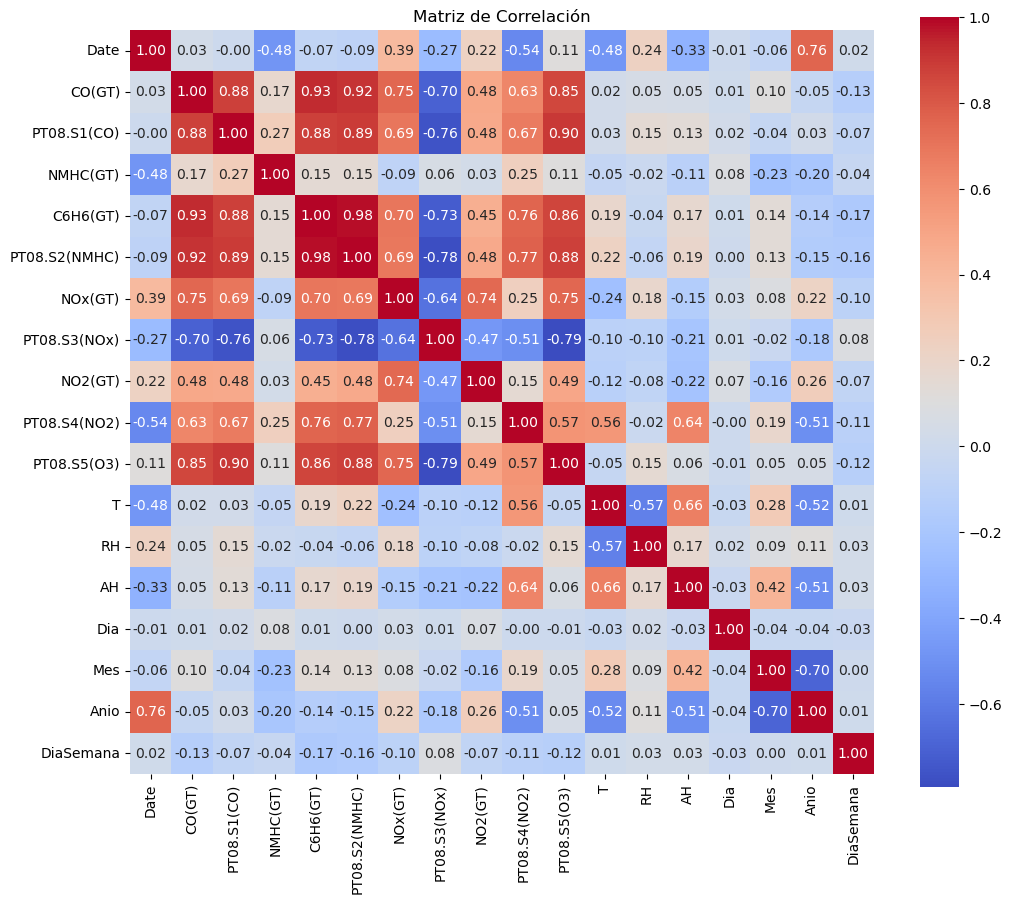

In [5]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

## Detección de Outliers Usando el Rango Intercuartílico (IQR)

### Concepto de Outliers
Los outliers (valores atípicos) son puntos de datos que se desvían significativamente del resto de las observaciones. Estos pueden influir de manera negativa en el análisis estadístico y en los modelos predictivos.

### Método del Rango Intercuartílico (IQR)
El rango intercuartílico (IQR) es una técnica comúnmente utilizada para identificar outliers. Este método funciona de la siguiente manera:
1. **Cálculo de los cuartiles:**
   - \( Q1 \): El primer cuartil (percentil 25) representa el valor por debajo del cual se encuentra el 25% de los datos.
   - \( Q3 \): El tercer cuartil (percentil 75) representa el valor por debajo del cual se encuentra el 75% de los datos.
2. **Cálculo del rango intercuartílico:**
   - \( IQR = Q3 - Q1 \).
3. **Determinación de los límites:**
   - **Límite inferior:** \( Q1 - 1.5 \times IQR \).
   - **Límite superior:** \( Q3 + 1.5 \times IQR \).
4. **Identificación de outliers:**
   - Cualquier valor que esté por debajo del límite inferior o por encima del límite superior se considera un outlier.

### Aplicación del Método
- La función toma como entrada un DataFrame y las columnas numéricas que serán evaluadas.
- Para cada columna, calcula \( Q1 \), \( Q3 \), el \( IQR \), y los límites inferior y superior.
- Identifica los valores fuera de estos límites y devuelve la cantidad de outliers junto con los límites calculados.

### Resultados
Al aplicar esta técnica:
- Se genera un informe que muestra:
  - La cantidad de outliers detectados en cada columna.
  - Los límites inferior y superior para identificar valores atípicos.
- Esto permite entender qué columnas tienen valores extremos y su impacto en el análisis de datos.

### Interpretación
El método del IQR es especialmente útil para identificar valores extremos en datos distribuidos aproximadamente de manera simétrica. Sin embargo, en datos sesgados o con distribuciones no normales, puede ser necesario ajustar el multiplicador de 1.5 para detectar outliers de manera más adecuada.


In [6]:
# Definir una función para detectar outliers usando el rango intercuartílico (IQR)
def detectar_outliers(df_cleaned, columnas):
    outliers_info = {}
    for columna in columnas:
        Q1 = df[columna].quantile(0.25)  # Primer cuartil (25%)
        Q3 = df[columna].quantile(0.75)  # Tercer cuartil (75%)
        IQR = Q3 - Q1  # Rango intercuartílico

        # Límites para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Identificar valores fuera de los límites
        outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
        outliers_info[columna] = {
            "Cantidad de outliers": len(outliers),
            "Límite inferior": limite_inferior,
            "Límite superior": limite_superior
        }
    return outliers_info

# Aplicar la función a las columnas numéricas de tu DataFrame
columnas_numericas = df.select_dtypes(include=[np.number]).columns
outliers = detectar_outliers(df, columnas_numericas)

# Mostrar resultados
for columna, info in outliers.items():
    print(f"Columna: {columna}")
    print(f" - Cantidad de outliers: {info['Cantidad de outliers']}")
    print(f" - Límite inferior: {info['Límite inferior']}")
    print(f" - Límite superior: {info['Límite superior']}")
    print()

Columna: CO(GT)
 - Cantidad de outliers: 1898
 - Límite inferior: -2.4
 - Límite superior: 5.6

Columna: PT08.S1(CO)
 - Cantidad de outliers: 484
 - Límite inferior: 471.0
 - Límite superior: 1671.0

Columna: NMHC(GT)
 - Cantidad de outliers: 914
 - Límite inferior: -200.0
 - Límite superior: -200.0

Columna: C6H6(GT)
 - Cantidad de outliers: 606
 - Límite inferior: -10.399999999999999
 - Límite superior: 28.0

Columna: PT08.S2(NMHC)
 - Cantidad de outliers: 426
 - Límite inferior: 120.0
 - Límite superior: 1696.0

Columna: NOx(GT)
 - Cantidad de outliers: 509
 - Límite inferior: -301.0
 - Límite superior: 635.0

Columna: PT08.S3(NOx)
 - Cantidad de outliers: 602
 - Límite inferior: 152.5
 - Límite superior: 1444.5

Columna: NO2(GT)
 - Cantidad de outliers: 1696
 - Límite inferior: -67.0
 - Límite superior: 253.0

Columna: PT08.S4(NO2)
 - Cantidad de outliers: 450
 - Límite inferior: 469.5
 - Límite superior: 2377.5

Columna: PT08.S5(O3)
 - Cantidad de outliers: 458
 - Límite inferior:

## Eliminación de Outliers Usando Z-Score

### Concepto de Z-Score
El Z-score es una métrica estadística que mide cuántas desviaciones estándar se encuentra un valor por encima o por debajo de la media. Se calcula como:

\[
Z = \frac{x - \mu}{\sigma}
\]

Donde:
- \( x \): Valor del dato.
- \( \mu \): Media de la columna.
- \( \sigma \): Desviación estándar de la columna.

Un Z-score alto o bajo indica que el valor está lejos de la media, y puede ser considerado un outlier si excede un umbral establecido (por ejemplo, 5 en este caso).

### Descripción del Código

1. **Selección de columnas numéricas:**
   - Se seleccionan únicamente las columnas que tienen datos numéricos (`float64` o `int64`), ya que el cálculo del Z-score solo aplica a valores numéricos.

2. **Manejo de valores nulos:**
   - Se eliminan las filas que tienen valores nulos en las columnas seleccionadas, ya que los valores faltantes pueden causar errores en el cálculo del Z-score.

3. **Conversión de datos a `float`:**
   - Todas las columnas numéricas se convierten al tipo `float` para evitar problemas de compatibilidad al calcular el Z-score.

4. **Cálculo de Z-scores:**
   - Se calcula el Z-score absoluto para cada valor en las columnas numéricas del DataFrame. Esto ayuda a identificar valores extremos tanto por encima como por debajo de la media.

5. **Creación del filtro:**
   - Se define un filtro que selecciona únicamente las filas donde **todos los valores Z-score son menores que el umbral establecido (5)**.

6. **Eliminación de filas con outliers:**
   - Se aplica el filtro para crear un nuevo DataFrame (`df_sin_outliers`) donde las filas con valores extremos han sido eliminadas.

7. **Información del DataFrame:**
   - Se imprimen detalles sobre el número de filas y columnas antes y después de la eliminación de outliers.
   - También se muestra una vista preliminar de las primeras filas del DataFrame limpio.

### Ventajas de Este Enfoque
- **Simplicidad:** El Z-score es fácil de calcular e interpretar.
- **Aplicabilidad:** Funciona bien en datos con distribuciones normales o aproximadamente normales.
- **Flexibilidad:** El umbral puede ajustarse según la sensibilidad deseada (5 en este caso).

### Limitaciones
- **Sensibilidad a distribuciones no normales:** En datos sesgados, el Z-score puede no ser ideal para detectar outliers.
- **Eliminación completa de filas:** Si una fila tiene un solo valor que excede el umbral, toda la fila se elimina, lo cual puede no ser deseable en ciertos casos.

### Interpretación de Resultados
- **Antes de eliminar outliers:** Muestra el tamaño original del DataFrame.
- **Después de eliminar outliers:** Muestra el tamaño reducido del DataFrame limpio, indicando cuántas filas se eliminaron.
- **Vista previa:** Permite verificar rápidamente que los valores extremos han sido eliminados del DataFrame.

Este método es una herramienta poderosa para preparar datos antes de realizar análisis o construir modelos predictivos.


In [7]:
from scipy.stats import zscore
import numpy as np

# Seleccionar columnas estrictamente numéricas
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Verificar que no hay valores nulos en las columnas seleccionadas
df = df.dropna(subset=columnas_numericas)

# Convertir todas las columnas numéricas a float para evitar errores con zscore
df[columnas_numericas] = df[columnas_numericas].astype(float)

# Calcular Z-scores para las columnas numéricas
zscores = np.abs(zscore(df[columnas_numericas]))

# Crear un filtro para las filas donde todos los Z-scores son menores que el umbral (5)
filtro = (zscores < 5).all(axis=1)

# Crear un nuevo DataFrame eliminando las filas que tienen outliers
df_sin_outliers = df[filtro]

# Mostrar información del DataFrame limpio
print("Antes de eliminar outliers:")
print(f"Filas: {len(df)}, Columnas: {len(df.columns)}")

print("\nDespués de eliminar outliers:")
print(f"Filas: {len(df_sin_outliers)}, Columnas: {len(df_sin_outliers.columns)}")

# Mostrar las primeras filas del DataFrame limpio
print("\nPrimeras filas del DataFrame sin outliers:")
print(df_sin_outliers.head())

print(df_sin_outliers.describe())


Antes de eliminar outliers:
Filas: 9357, Columnas: 18

Después de eliminar outliers:
Filas: 9270, Columnas: 18

Primeras filas del DataFrame sin outliers:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            939      131   
3 2004-03-10       2         1376        80         9            948      172   
4 2004-03-10       2         1272        51         6            836      131   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  T  RH  AH  Dia  Mes  \
0          1056      113          1692         1268 14  49   1   10    3   
1          1174       92          1559          972 13  48   1   10    3   
2          1140      114          1555         1074 12  54   1   10    3   
3          1092      122          1584         1203 11

# Definición de Predictores y Objetivos
Se definen las variables predictoras y las variables objetivo que se utilizarán en el análisis o modelado.

## Predictores
- Los **predictores** son las variables independientes, también conocidas como **features** o características.
- Representan los datos que se utilizarán como entrada para realizar predicciones.
- En este caso, los predictores seleccionados son:
  - **T**: Temperatura.
  - **RH**: Humedad relativa.
  - **AH**: Humedad absoluta.

## Objetivos
- Los **objetivos** son las variables dependientes o **targets**.
- Representan los valores que queremos predecir o explicar utilizando los predictores.
- En este caso, los objetivos seleccionados son:
  - **PT08.S1(CO)**: Concentración medida por un sensor relacionado con CO (monóxido de carbono).
  - **PT08.S2(NMHC)**: Concentración medida por un sensor relacionado con compuestos no metánicos (NMHC).
  - **PT08.S3(NOx)**: Concentración medida por un sensor relacionado con óxidos de nitrógeno (NOx).
  - **PT08.S4(NO2)**: Concentración medida por un sensor relacionado con dióxido de nitrógeno (NO2).

## División en Variables Predictoras y Objetivo
- Las variables se dividen en dos conjuntos principales:
  - `X`: Contiene las variables predictoras, seleccionadas de las columnas del conjunto de datos limpio (`df_cleaned`) correspondientes a **T**, **RH** y **AH**.
  - `y`: Contiene las variables objetivo, seleccionadas de las columnas correspondientes a los sensores mencionados.

Esta separación es esencial para entrenar modelos predictivos, ya que `X` proporciona la información utilizada para hacer predicciones, y `y` se usa como referencia para evaluar la precisión del modelo.


In [8]:
# Definir predictores y objetivos
predictors = ['T', 'RH', 'AH']
targets = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']

X = df_sin_outliers[predictors]
y = df_sin_outliers[targets]

# Normalización y Separación de los Datos
En este paso, se realizan dos tareas fundamentales para preparar los datos para su uso en un modelo de aprendizaje automático: **normalización** y **división en conjuntos de entrenamiento y prueba**.

## Normalización
La normalización es un proceso que ajusta los valores de las variables predictoras para que estén dentro de un rango común, generalmente entre 0 y 1. Esto es especialmente importante cuando las variables tienen escalas muy diferentes, ya que ayuda a que los modelos de aprendizaje automático converjan más rápido y de manera más eficiente.

### ¿Cómo se realizó la normalización?
1. Se utilizó el objeto `MinMaxScaler` de la biblioteca `sklearn`, que escala cada característica a un rango entre 0 y 1.
2. El método `fit_transform` se aplicó a las variables predictoras (`X`), ajustando los datos al rango deseado y transformándolos en consecuencia.
3. El resultado, almacenado en `X_scaled`, es una versión escalada de las variables predictoras.


## División en Conjuntos de Entrenamiento y Prueba
Después de la normalización, los datos se dividen en dos subconjuntos:
- **Conjunto de entrenamiento**: Se utiliza para entrenar el modelo.
- **Conjunto de prueba**: Se utiliza para evaluar el rendimiento del modelo con datos que no ha visto antes.

### ¿Cómo se realizó la división?
1. Se utilizó la función `train_test_split` de `sklearn`:
   - `X_scaled`: Variables predictoras ya normalizadas.
   - `y`: Variables objetivo.
2. Se especificó una proporción del 20% para el conjunto de prueba (`test_size=0.2`), lo que significa que el 80% de los datos se utilizarán para el entrenamiento y el 20% para la validación.
3. El argumento `random_state=42` asegura que la división sea reproducible, permitiendo obtener los mismos resultados en ejecuciones futuras.

### Resultado de la división:
- **`X_train` y `y_train`**: Datos de entrenamiento (80% del total).
- **`X_test` y `y_test`**: Datos de prueba (20% del total).


### Importancia de estos pasos
1. **Normalización**: Ayuda a mejorar el rendimiento de los modelos al garantizar que todas las variables estén en la misma escala.
2. **División en conjuntos de entrenamiento y prueba**: Permite evaluar el modelo de manera justa con datos que no ha visto durante el entrenamiento, evitando el sobreajuste.


In [9]:
# normalización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Separar datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Definición y Configuración de los Modelos

En esta sección, se define una variedad de modelos de regresión y sus respectivos hiperparámetros para realizar experimentos y comparar su rendimiento.

## Modelos Incluidos
Se seleccionaron diferentes algoritmos de regresión que cubren múltiples enfoques y técnicas.

1. **Regresión Lineal (Linear Regression)**:
   - Modelo simple basado en la relación lineal entre las variables predictoras y el objetivo.
   - No requiere hiperparámetros.

2. **Árbol de Decisión (Decision Tree Regressor)**:
   - Modelo basado en divisiones secuenciales de los datos según características relevantes.
   - Hiperparámetros:
     - `max_depth`: Profundidad máxima del árbol.
     - `min_samples_split`: Número mínimo de muestras necesarias para dividir un nodo.

3. **Bosque Aleatorio (Random Forest Regressor)**:
   - Ensamble de múltiples árboles de decisión que promedian los resultados para mejorar la precisión.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el bosque.
     - `max_depth`: Profundidad máxima de los árboles.
     - `min_samples_split`: Requisito mínimo de muestras para dividir nodos.

4. **Gradient Boosting Regressor**:
   - Modelo de ensamble que ajusta secuencialmente árboles para minimizar el error residual.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el ensamble.
     - `learning_rate`: Tasa de aprendizaje que controla el impacto de cada árbol.
     - `max_depth`: Profundidad máxima de los árboles.

5. **Regresor de Vectores de Soporte (Support Vector Regressor - SVR)**:
   - Modelo que encuentra un hiperplano en un espacio dimensional alto para realizar predicciones.
   - Hiperparámetros:
     - `C`: Penalización de errores (regularización).
     - `kernel`: Tipo de núcleo para transformar los datos (e.g., `linear`, `rbf`).
     - `epsilon`: Margen de tolerancia alrededor del hiperplano.

6. **XGBoost Regressor**:
   - Modelo avanzado basado en gradient boosting que incluye optimizaciones de regularización.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles.
     - `learning_rate`: Tasa de aprendizaje.
     - `max_depth`: Profundidad máxima de los árboles.
     - `subsample`: Fracción de datos utilizada en cada iteración.

7. **Red Neuronal (Neural Network - MLPRegressor)**:
   - Modelo inspirado en la estructura del cerebro humano, útil para capturar relaciones no lineales complejas.
   - Hiperparámetros:
     - `hidden_layer_sizes`: Configuración del número de neuronas en cada capa oculta.
     - `activation`: Función de activación (`relu`, `tanh`).
     - `solver`: Algoritmo de optimización (`adam`, `sgd`).
     - `learning_rate`: Estrategia para ajustar la tasa de aprendizaje (`constant`, `adaptive`).


## Configuración de los Modelos
- Cada modelo se define junto con un conjunto de posibles valores para sus hiperparámetros, organizados en un diccionario llamado `param_grids`.
- Este diccionario permite automatizar la búsqueda de combinaciones óptimas de hiperparámetros mediante técnicas como la búsqueda en malla (grid search) o búsqueda aleatoria (random search).

## Resultados
- Se crea un diccionario vacío llamado `results` que será utilizado para almacenar los resultados de cada modelo y las combinaciones de hiperparámetros evaluados.
- Esto facilita la comparación y selección del modelo más adecuado según los datos y la métrica de evaluación seleccionada.

### Importancia de este Enfoque
1. **Diversidad de Modelos**:
   - Permite probar múltiples enfoques para identificar el más adecuado para el problema.
   
2. **Optimización de Hiperparámetros**:
   - La configuración de hiperparámetros es clave para maximizar el rendimiento de cada modelo.

3. **Flexibilidad**:
   - Facilita la experimentación y la posibilidad de extender el análisis a otros algoritmos en el futuro.



In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Definir modelos y sus hiperparámetros
param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

results = {}


# Optimización, Evaluación y Comparación de Modelos
En esta sección, se lleva a cabo la optimización de hiperparámetros, el entrenamiento y la evaluación de diferentes modelos de regresión para cada variable objetivo. Además, se visualizan los resultados y se analizan métricas clave como el MSE, el R² y el sobreajuste.

## Optimización de Hiperparámetros
1. **Selección de Variable Objetivo**:
   - Cada modelo se entrena y evalúa individualmente para cada una de las variables objetivo definidas anteriormente (e.g., `PT08.S1(CO)`).

2. **Configuración de `GridSearchCV`**:
   - Se utiliza `GridSearchCV` para realizar una búsqueda exhaustiva de las mejores combinaciones de hiperparámetros para cada modelo.
   - Configuraciones clave:
     - `cv=5`: Validación cruzada con 5 particiones.
     - `scoring='neg_mean_squared_error'`: Métrica de evaluación basada en el MSE.
     - `n_jobs=-1`: Uso de todos los núcleos disponibles para acelerar el proceso.

3. **Entrenamiento y Selección del Mejor Modelo**:
   - Para cada combinación de hiperparámetros, `GridSearchCV` ajusta el modelo y evalúa su desempeño.
   - Se selecciona el modelo con el menor error cuadrático medio (MSE).

## Evaluación de los Modelos
1. **Predicciones**:
   - Los modelos seleccionados generan predicciones para los conjuntos de entrenamiento y prueba.
2. **Cálculo de Métricas**:
   - **MSE** (Mean Squared Error):
     - Mide el promedio de los errores al cuadrado.
     - Cuanto menor sea el valor, mejor es el modelo.
   - **R²** (Coeficiente de Determinación):
     - Indica la proporción de la varianza explicada por el modelo.
     - Valores más cercanos a 1 indican mejor desempeño.
3. **Análisis de Sobreajuste**:
   - Se calcula la diferencia entre el R² de entrenamiento y el de prueba para medir el nivel de sobreajuste.

## Almacenamiento y Visualización de Resultados
### Resultados Consolidados
- Se crea un DataFrame (`results_df`) que organiza los resultados de cada modelo y variable objetivo:
  - Métricas de entrenamiento y prueba (MSE y R²).
  - Hiperparámetros seleccionados.
  - Diferencia entre R² de entrenamiento y prueba (indicador de sobreajuste).

### Visualizaciones
1. **Nivel de Sobreajuste**:
   - Gráfico de barras que muestra la diferencia entre el R² de entrenamiento y prueba para cada modelo y variable objetivo.
   - Ayuda a identificar modelos que podrían estar ajustando en exceso los datos de entrenamiento.

2. **Comparación de R²**:
   - Gráfico de barras que compara el R² de prueba de cada modelo para cada variable objetivo.
   - Permite identificar qué modelos explican mejor la varianza de los datos.

3. **Comparación de MSE**:
   - Gráfico de barras que muestra los valores de MSE de prueba para cada modelo y variable objetivo.
   - Los valores más bajos indican un mejor desempeño.

## Importancia del Análisis
1. **Optimización Eficiente**:
   - `GridSearchCV` permite probar combinaciones de hiperparámetros de manera eficiente y sistemática.
   
2. **Evaluación Completa**:
   - El uso de múltiples métricas (MSE y R²) proporciona una evaluación integral del desempeño de los modelos.

3. **Detección de Sobreajuste**:
   - El análisis de sobreajuste garantiza que los modelos seleccionados generalicen bien a datos no vistos.

4. **Visualización Intuitiva**:
   - Los gráficos facilitan la comparación de modelos y métricas clave, ayudando en la toma de decisiones.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


# Entrenar y evaluar cada modelo por variable objetivo
for target in targets:
    print(f"\nOptimización de hiperparámetros para el objetivo: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    results[target] = {}
    
    for name, config in param_grids.items():
        model = config['model']
        params = config['params']
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train_target)
        
        # Mejor modelo y evaluación
        best_model = grid_search.best_estimator_
        
        # Predicciones en entrenamiento y prueba
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calcular métricas
        mse_train = mean_squared_error(y_train_target, y_train_pred)
        mse_test = mean_squared_error(y_test_target, y_test_pred)
        r2_train = r2_score(y_train_target, y_train_pred)
        r2_test = r2_score(y_test_target, y_test_pred)
        
        # Guardar resultados
        results[target][name] = {
            'Best Params': grid_search.best_params_,
            'MSE Train': mse_train,
            'MSE Test': mse_test,
            'R2 Train': r2_train,
            'R2': r2_test  # R2 de prueba
        }
        print(f"{name} mejor MSE: {mse_test:.4f}, R2: {r2_test:.4f}, Hiperparámetros: {grid_search.best_params_}")

# # Crear un DataFrame con los resultados finales
# rows = []
# for target, metrics in results.items():
#     for name, scores in metrics.items():
#         rows.append({
#             'Target': target,
#             'Model': name,
#             'MSE Train': scores['MSE Train'],
#             'MSE Test': scores['MSE Test'],
#             'R2 Train': scores['R2 Train'],
#             'R2': scores['R2'],
#             'Overfitting': scores['R2 Train'] - scores['R2'],  # Calcular sobreajuste
#             'Best Params': scores['Best Params']
#         })

# results_df = pd.DataFrame(rows)

# # Mostrar la tabla de resultados
# print("Resultados Finales:")
# print(results_df)


Optimización de hiperparámetros para el objetivo: PT08.S1(CO)
Linear Regression mejor MSE: 42705.4774, R2: 0.5888, Hiperparámetros: {}
Decision Tree mejor MSE: 44427.0910, R2: 0.5723, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 5}
Random Forest mejor MSE: 40015.0827, R2: 0.6147, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting mejor MSE: 40846.8403, R2: 0.6067, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Support Vector Regressor mejor MSE: 43818.6461, R2: 0.5781, Hiperparámetros: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
XGBoost mejor MSE: 40521.8210, R2: 0.6099, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Neural Network mejor MSE: 43042.1366, R2: 0.5856, Hiperparámetros: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}

Optimización de hiperparámetros para el objetivo: PT08.S2(NMHC)
Linear R

ver graficos de R2, MSE y Sobreajuste 

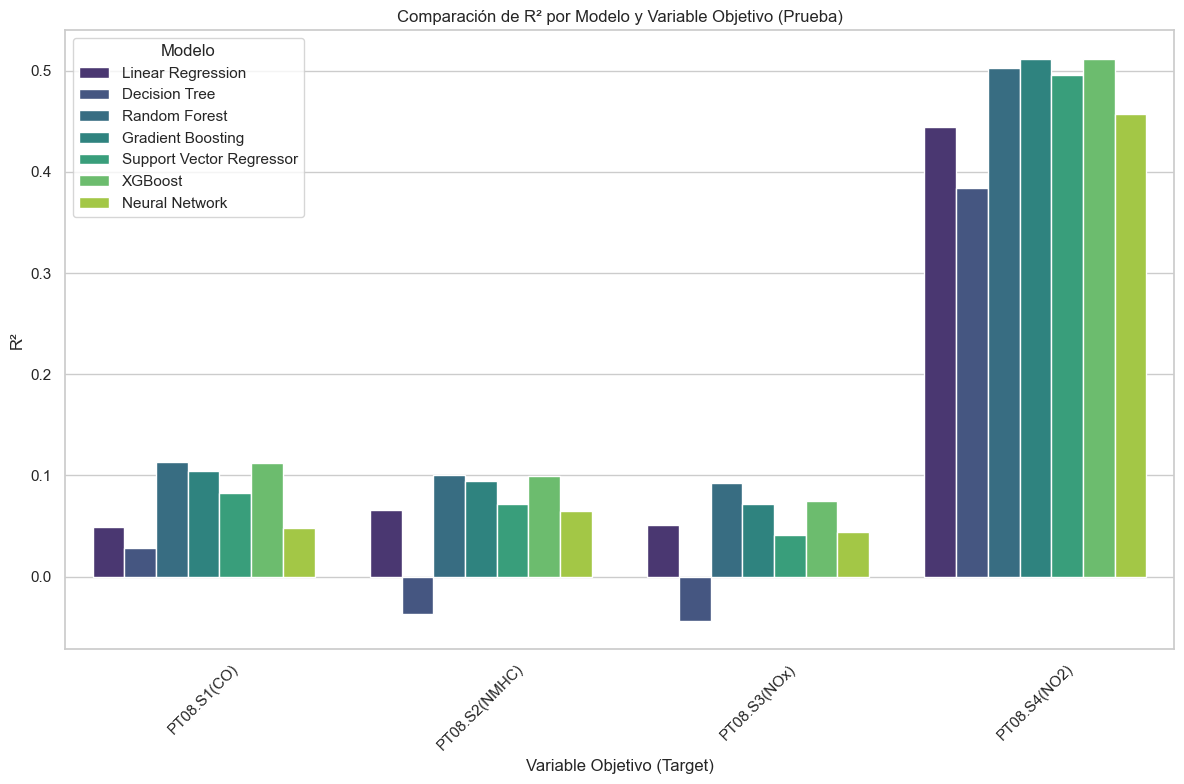

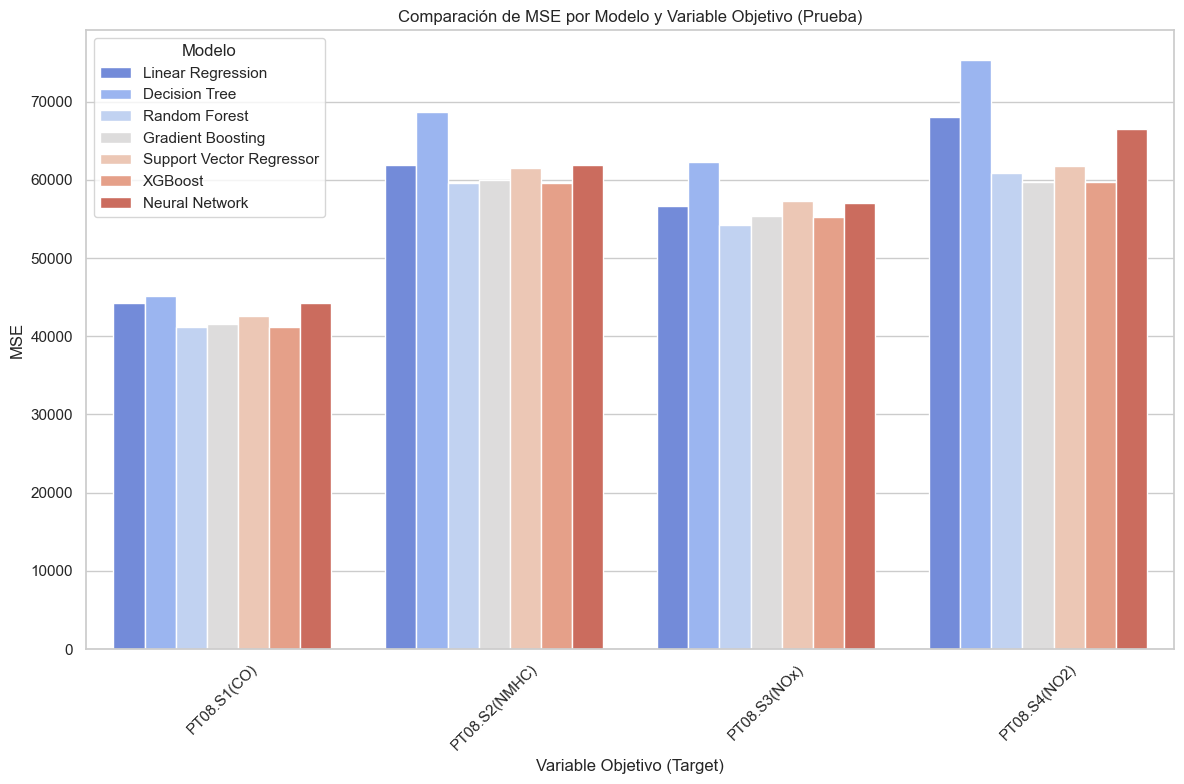

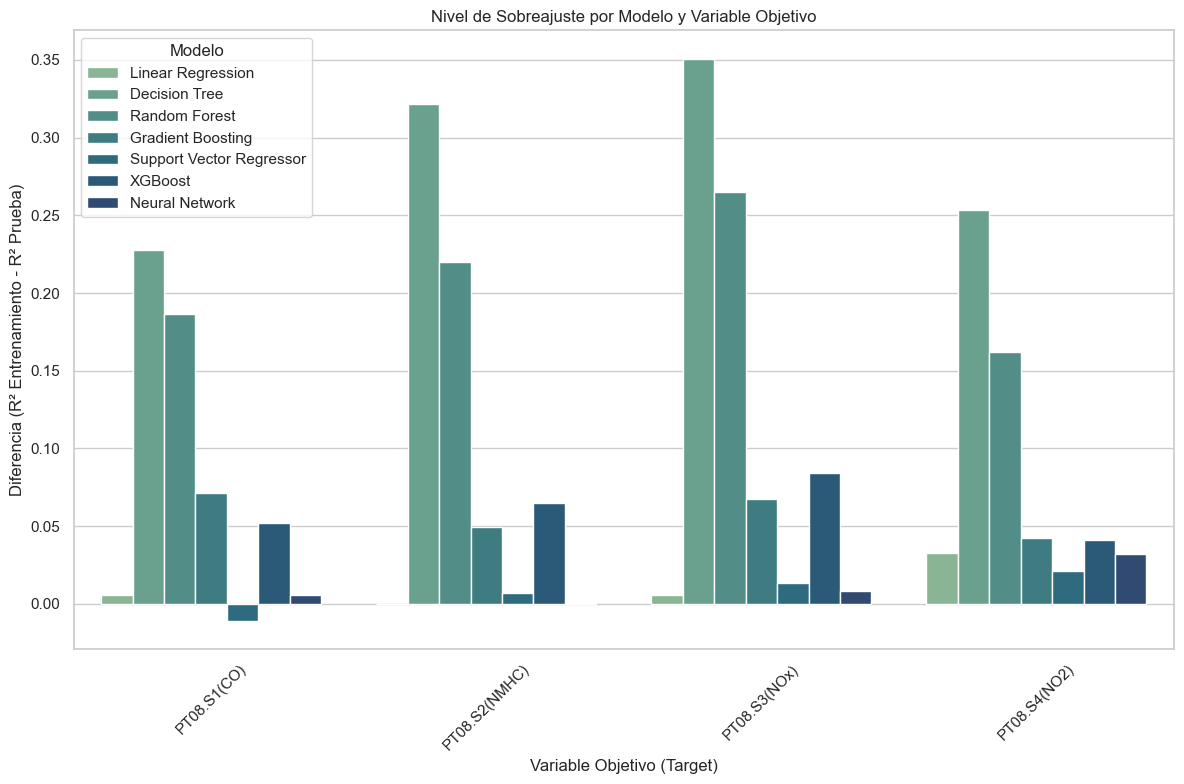

In [107]:
# Convertir los resultados en un DataFrame para facilitar la visualización
rows = []
for target, metrics in results.items():
    for name, scores in metrics.items():
        rows.append({
            'Target': target,
            'Model': name,
            'MSE Train': scores['MSE Train'],
            'MSE Test': scores['MSE Test'],
            'R2 Train': scores['R2 Train'],
            'R2 Test': scores['R2'],  # R2 de prueba
            'Overfitting': scores['R2 Train'] - scores['R2'],  # Calcular sobreajuste
            'Best Params': scores['Best Params']
        })

results_df = pd.DataFrame(rows)

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de R² (entrenamiento vs prueba)
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='R2 Test', hue='Model', palette='viridis')
plt.title("Comparación de R² por Modelo y Variable Objetivo (Prueba)")
plt.ylabel("R²")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de MSE (entrenamiento vs prueba)
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='MSE Test', hue='Model', palette='coolwarm')
plt.title("Comparación de MSE por Modelo y Variable Objetivo (Prueba)")
plt.ylabel("MSE")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de sobreajuste
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='Overfitting', hue='Model', palette='crest')
plt.title("Nivel de Sobreajuste por Modelo y Variable Objetivo")
plt.ylabel("Diferencia (R² Entrenamiento - R² Prueba)")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Análisis

### Modelos con alto sobreajuste
- Los modelos con barras más altas (por ejemplo, **Decision Tree** y **Random Forest**) tienen un mayor nivel de sobreajuste.
- Esto sugiere que están demasiado ajustados a los datos de entrenamiento y generalizan mal a los datos de prueba.

### Modelos con bajo sobreajuste
- Los modelos con barras más bajas (cercanas a 0) tienen menos sobreajuste.
- Esto indica que el rendimiento en entrenamiento y prueba es similar, lo cual es deseable.

### Diferencias entre variables objetivo
- El nivel de sobreajuste varía según la variable objetivo. Por ejemplo:
  - Para **PT08.S1(CO)** y **PT08.S3(NOx)**, los modelos tienen diferencias moderadas en el nivel de sobreajuste.
  - Para **PT08.S2(NMHC)** y **PT08.S4(NO2)**, algunos modelos muestran niveles significativamente altos de sobreajuste.

## Conclusión

### Evaluar modelos
- Los modelos como **Decision Tree** y **Random Forest** muestran altos niveles de sobreajuste en este gráfico.
- Esto podría deberse a una falta de regularización o a hiperparámetros que permiten demasiada complejidad.

### Modelos recomendados
- Los modelos con menor sobreajuste, como **Linear Regression** o **Gradient Boosting**, podrían ser mejores opciones si buscas un balance entre rendimiento en entrenamiento y generalización.


PARTE DE MIA IMANOL

In [32]:
import joblib

# Cargar el modelo en Python 3
model = joblib.load('modelo_xgb_optimizado.pkl')

# Guardarlo nuevamente en un formato compatible con Python 2 (protocolo 2)
joblib.dump(model, 'modelo_xgb_optimizado_v2.pkl', protocol=2)

['modelo_xgb_optimizado_v2.pkl']